# Проект Danss
В данном проекте определяются поправки к зависимости осциляций нетрино от пройденого пути вызваные не точечностью источника частиц и детектора.



## Задача
Определить распределение электроного и мюоного нейтрино в детекторе расположеного возле реактора.


## Геометрия задачи
Рассмотрим следующию модель:реактор - цилиндр с высотой H и радиусом R

*   реактор - цилиндр с высотой $H$ и радиусом $R$
*   детектор - куб с длиной ребра $a$
*   Взаимное расположение: куб и цилиндр стоят на одной плоскости. $L$ - растояие между центрами фигур, $\theta$ - угол поворота куба в этой плоскости
(т.е. угл между прямой соединяющей центры фигур и нормалью грани)

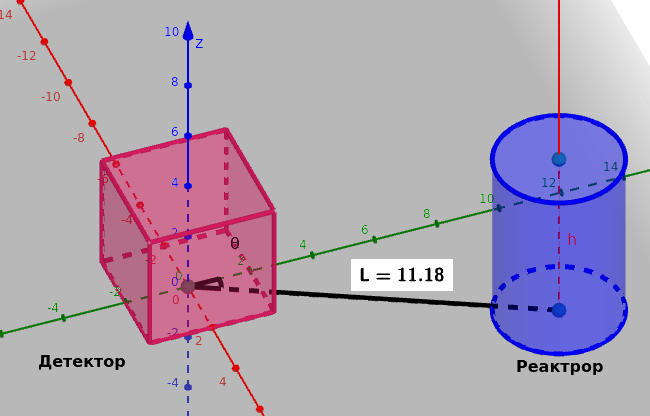

Если мы будим использовать декардовы координаты от центра основания для точки из детектора ($x, y, z$) и цилиндрические координаты для точки из реактора ($h, r, \varphi$), то растояние между точкой из реактора и точкой из детектора будет:

$ l=\sqrt{(L-r\cos \varphi -y\cos θ +x\sin θ)^2 + (r\sin \varphi +y\sin θ +x\cos θ)^2 +(z-h)^2}$

Распределение растояний будет тогда:

$$ F(l) = \frac{\int_{l(...)=l}{dxdydzdhdrdφ}}{\int{dxdydzdhdrdφ}}=\frac{1}{\pi R^2Ha^3}\int_{l(...)=l}{dxdydzdhdrdφ}$$

Как видно, в явном виде посчитать этот интеграл не представляется возможным.

Для нахождения F(l) сделаем численый расчёт.

В эксперименте на Калининской АЭС геометрические параметры следующие:

$a=1\ \text{м},\ R=2\ \text{м},\ H=2\ \text{м},\ L=9-11\ \text{м}$

## Численый метод определения распределения
Код находится в "main.cpp"

### Метод прямого перебора

В методе прямого перебора мы создаём регулярную сетку точек в объёмах куба и цилиндра с неким шагом.

```
void BruteForceMethod(double delita, distance* dist, histogram* F, double H, double R, double a){
    int H_max = int(H/delita);
    int R_max = int(R/delita);
    int a_max = int(a/delita);
    for (int i_z = 0; i_z<= a_max; i_z++){
        for (int i_y = -a_max/2; i_y<= a_max/2; i_y++){
            for (int i_x = -a_max/2; i_x <= a_max/2; i_x++){
                for (int i_r = 0; i_r<= R_max*R_max; i_r++){
                    for (int i_phi = 0; i_phi< int(2*M_PI/delita); i_phi++){
                        for (int i_h = 0; i_h<= H_max; i_h++){
                            F->push_point(dist->operator()(i_x, i_y, i_z, std::sqrt(i_r), i_phi, i_h));    
    };};};};};};};
```


Главный недостаток даного метода связан с длительностью исполнения вложеных циклов при достаточно малого шага сетки (число пар растёт как $(\frac{\text{размеры тел}}{ϵ})^6 \sim 10^{3*6}$).

### Метод Монте-Карло
Для ускорения расчёта мы можем генерировать две случайые точки с равномерным распределением в объёмах детектора и реактора, а потом определять растоянием между ними. Таким образом мы пролучаем репрезентативную выборотку пар точек и соотвествующих длин.
Даный метод работает быстрее потому что достаточно сгенерировать выборотку длиной примерно $10^6$

Один из главных моментов в методе является правильный выбор распределения вероятностей в ГПСЧ. Наша цель сделать равномерно по объёму, т.е. т.е. для любого интегрирования плотности в. по равновеликим фигурам даёт одно и тоже значение вероятности.
Есть два варианта (по x,y,z,h вопросов нет):
*   равномерно по $φ$ и $r$, тогда в центре "плотнее"
*   равномерно по $φ$ и $\frac{r^2}{2}$ (так как $ds=rdr d\varphi$)

```
void MonteKarloMethod(int N, distance* dist, histogram* F, double H, double R, double a){
    std::uniform_real_distribution<double> unif(0,1);   //ГПСЧ
    std::default_random_engine re;
    for (int i = 0; i< N; i++){
        double r_x = unif(re)*a - a/2;
        double r_y = unif(re)*a - a/2;
        double r_z = unif(re)*a;
        double r_r = std::sqrt(unif(re)*R*R);
        double r_phi = unif(re)*2*M_PI;
        double r_h = unif(re)*H;
        F->push_point(dist->operator()(r_x, r_y, r_z, r_r, r_phi, r_h));  
    };
};
```

При втором варианте достигается требуемый вариант.


### Отрисовка распределения
Воспользуемся пакетами matplotlib

In [1]:
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [2]:
#Получение данных гистограммы

data=[]
with open('Data_end', 'r') as file:
    arr=file.readlines()
    for line in arr[10:]:
        data.append(int(line))
    # arrx, arrx, arrz = arr[1].split()
    # H = float(arrz)
    # arrx, arrx, arrz = arr[2].split()
    # R = float(arrz)
    # arrx, arrx, arrz = arr[3].split()
    # a = float(arrz)
    # arrx, arrx, arrz = arr[4].split()
    # L = float(arrz)
    # arrx, arrx, arrz = arr[5].split()
    # theta = float(arrz)
    arrx, arrx, arrx, arry, arrz = arr[6].split()
    x_max = float(arry)
    x_min = float(arrz)
    arrx, arrx, arrz = arr[7].split()
    err = float(arrz)

# data = np.loadtxt('Data_end', skiprows = 1)
# x_min =
# err =

In [3]:
#Обработка (добавление длин)
l=[]
for i in range(len(data)):
    l.append(x_min+ i*err)

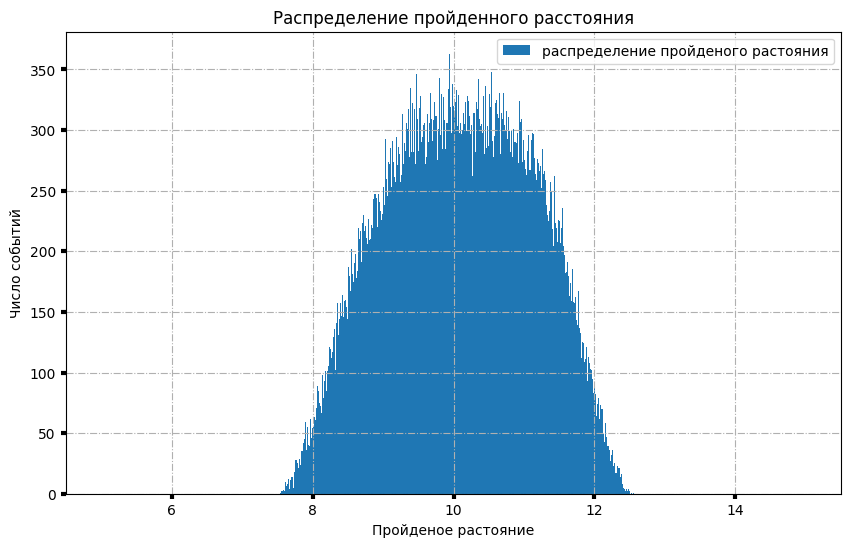

In [4]:
#Рисование гистограммы и другое
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Распределение пройденного расстояния')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")

ax.legend()
pyplot.show()

## Фитирование распределения $F(l)$

Воспользуемся пакетами scipy.optimize для фитирования полученной гистограммы.

In [5]:
#Фитирование (библиотеки)
from scipy.optimize import curve_fit
from scipy.special import  erf
from math import exp

In [6]:
# Границы фитирования
flag = 0;
for i in range(len(data)):
  if flag == 0 and data[i]>0:
    i_min = i
    flag = 1
  if flag == 1 and data[i] ==0 and i<(i_min+30):
    i_min = i
  if flag == 1 and data[i] ==0 and i>(i_min+30):
    i_max=i
    break
print(i_min, i_max)

254 751


### Гауссов пик и ему подобные
Так как внешний вид распределерия схожен с нормальным расспределением, то попробуем использовать гаусовы и ему подобные распределения

In [7]:
#Пробная функция - квадратичная
def parab(x, a, b, c):
    return c-a*np.power(np.abs(x-b), 2)
args_p, covar_p = curve_fit(parab, l[i_min+100:i_max-100], data[i_min+100:i_max-100], [1.,10.0, 400.0])
perr = np.sqrt(np.diag(covar_p))
print("Результаты фитирования параболой: ", args_p, " и их ошибка", perr)

Результаты фитирования параболой:  [ 50.62631549  10.15948958 319.14826557]  и их ошибка [1.59454432 0.01285058 1.55889193]


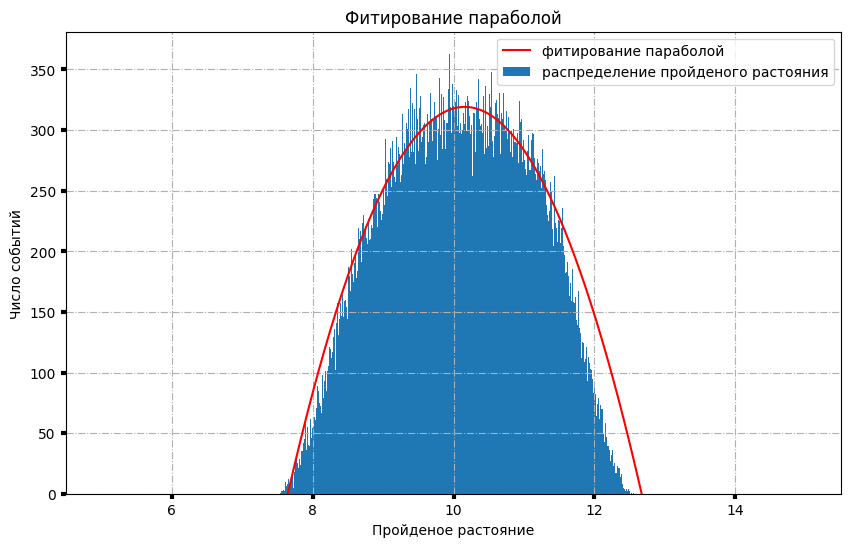

In [8]:
x = []
y = []
for i in range(len(l)):
    if parab(l[i], args_p[0], args_p[1], args_p[2]) > 0:
      x.append(l[i])
      y.append(parab(l[i], args_p[0], args_p[1], args_p[2]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование параболой')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(x, y, color='r', label = "фитирование параболой")
ax.legend()
pyplot.show()

In [9]:
#Фитирование гаусовым пиком
def gauss(x, a, b, c, d):
    return a*np.exp(-(x-b)**2 /c)+d
args, covar = curve_fit(gauss, l[i_min:i_max], data[i_min:i_max], [300000.0,11.0, 100.0,0.0])
perr = np.sqrt(np.diag(covar))
args, perr

# Подсчёт хи квадрата
chisq=0
for i in range(i_min, i_max):
    if data[i]>0:
        chisq += (data[i] - gauss(l[i], *args))**2/ data[i]
    else:
        chisq += (data[i] - gauss(l[i], *args))**2
print("Результаты фитирования гауссом: ", args_p, " и их ошибка", perr)
print("Хи квадрат: ",chisq)
print("Уделёный на число степеней свобод: ", chisq/(i_max - i_min - 3))

Результаты фитирования гауссом:  [ 50.62631549  10.15948958 319.14826557]  и их ошибка [2.29062770e+02 5.46033259e-03 3.95512369e+00 2.29992210e+02]
Хи квадрат:  7084.138777589329
Уделёный на число степеней свобод:  14.340361897954107


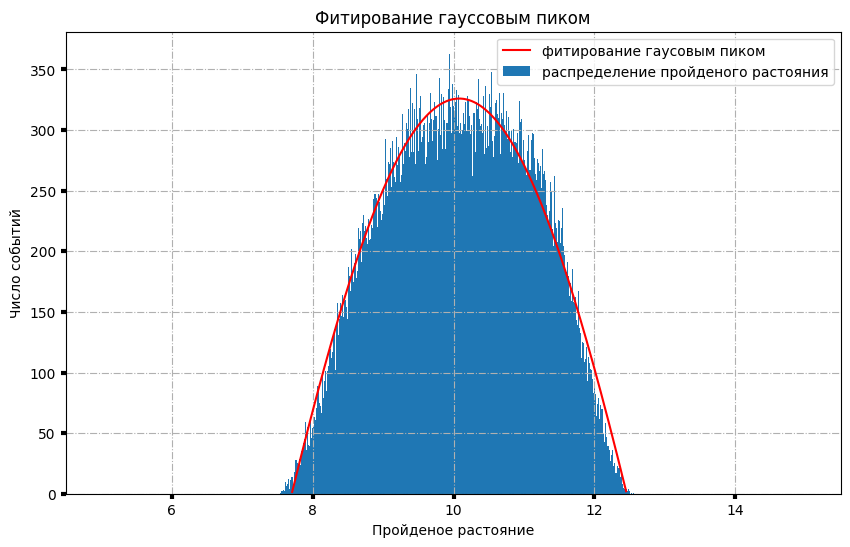

In [10]:
xx = []
yy = []
for i in range(i_min, i_max):
    if gauss(l[i], args[0], args[1], args[2], args[3]) > 0:
      xx.append(l[i])
      yy.append(gauss(l[i], args[0], args[1], args[2], args[3]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Фитирование гауссовым пиком')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)


ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
ax.plot(xx, yy, color='r', label = "фитирование гаусовым пиком")
ax.legend()
pyplot.show()

### Полиномы

In [11]:
#Фитирование полиномом
def pol_6(x, a, b, c, d, f, g, h):
    return a+b*x+c*x**2+d*x**3+f*x**4+g*x**5+h*x**6
def pol_3(x, a, b, c, d):
    return a+b*x+c*x**2+d*x**3

args_6, covar_6 = curve_fit(pol_6, l[i_min:i_max], data[i_min:i_max], absolute_sigma=True)
perr_6 = np.sqrt(np.diag(covar_6))
print("6: ", args_6, perr_6)
args_3, covar_3 = curve_fit(pol_3, l[i_min:i_max], data[i_min:i_max], absolute_sigma=True)
perr_3 = np.sqrt(np.diag(covar_3))
print("3: ", args_3, perr_3)

# Подсчёт хи квадрата
chisq = 0
for i in range(i_min, i_max):
    r = data[i] - pol_6(l[i], *args_6)
    chisq += r**2/ data[i]
print("chisq =",chisq)
print(chisq/(i_max - i_min - 7))

6:  [ 2.01584914e+06 -1.24067403e+06  3.16175312e+05 -4.27247710e+04
  3.22998561e+03 -1.29552224e+02  2.15381067e+00] [9.27490201e+03 5.70194667e+03 1.45270209e+03 1.96333965e+02
 1.48465957e+01 5.95630837e-01 9.90540894e-03]
3:  [-2522.18182328   232.37718345    36.76542086    -3.15761653] [18.88866373  5.77285095  0.58171994  0.01933498]
chisq = 837.7982789852894
1.7097924060924272


power =  6
 args =  [ 2.01581016e+06 -1.24064767e+06  3.16167991e+05 -4.27237005e+04
  3.22989863e+03 -1.29548497e+02  2.15374485e+00]
 chi sq = 837.9232176461907
  1.7100473829514096


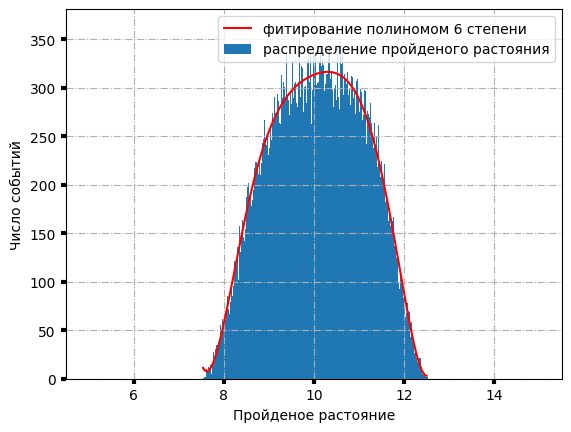

power =  7
 args =  [ 9.70995343e+04  1.40665301e+05 -1.07904743e+05  2.92487830e+04
 -4.06313065e+03  3.11700672e+02 -1.26065408e+01  2.10603239e-01]
 chi sq = 688.9638235029938
  1.40892397444375


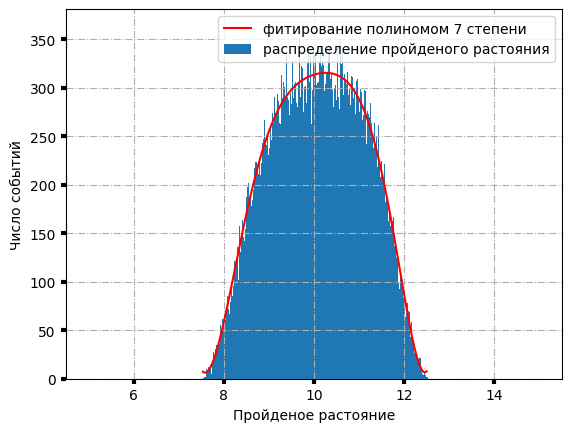

power =  8
 args =  [-9.90400920e+05  9.25610473e+05 -3.49911671e+05  7.06036555e+04
 -8.30146685e+03  5.73349359e+02 -2.17276651e+01  3.57078116e-01
 -4.12621082e-04]
 chi sq = 660.5461230076047
  1.3535781209172228


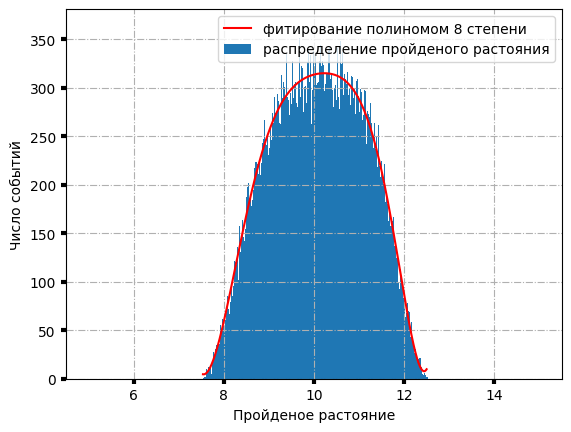

power =  9
 args =  [-6.16199410e+06  4.87148421e+06 -1.61975935e+06  2.89835511e+05
 -2.89958264e+04  1.37520549e+03  1.15229988e+01 -4.83235030e+00
  2.23475223e-01 -3.52141305e-03]
 chi sq = 586.3248997549551
  1.2039525662319408


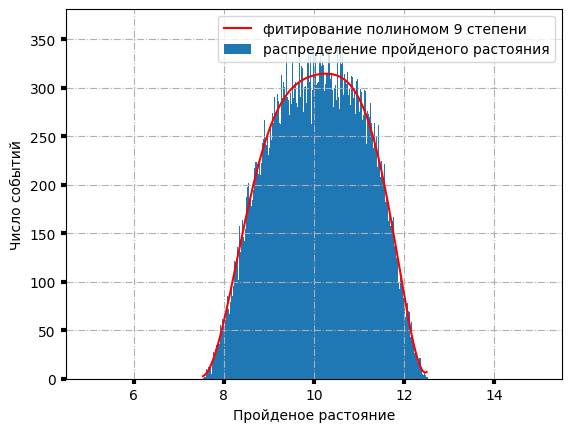

In [14]:
a_zero = args_6
for i_pow in range(7, 11):
    def pol(x, *a):
        s = a[0]
        for i in range(1, i_pow):
            s+=a[i]*(x**i)
        return s
    args, covar = curve_fit(pol, l[i_min:i_max], data[i_min:i_max], a_zero, absolute_sigma=True)

    a_zero = np.append(args, 0.0)

    perr = np.sqrt(np.diag(covar))
    print("power = ", i_pow-1)
    print(" args = ", args)

    # Подсчёт хи квадрата
    chisq=0
    for i in range(i_min, i_max):
        if data[i]>0:
          chisq += (data[i] - pol(l[i], *args))**2/ data[i]
        else:
          chisq += (data[i] - pol(l[i], *args))**2
    print(" chi sq =",chisq)
    print(" ", chisq/(i_max - i_min - i_pow))

    #Отрисовка
    x = []
    y = []
    for i in range(i_min, i_max):
        if pol(l[i], *args) > 0:
          x.append(l[i])
          y.append(pol(l[i], *args))

    fig, ax = plt.subplots()
    ax.set_xlabel('Пройденое растояние')
    ax.set_ylabel('Число событий')
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize='medium', width=3)

    ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
    ax.plot(x, y, color='r', label = "фитирование полиномом "+str(i_pow-1)+ " степени")
    ax.legend()
    pyplot.show()


power =  7
 args =  [ 4.61274784e-02  1.86068486e+05 -4.11152271e+04  1.39100040e+04
 -2.10440671e+03  1.68823920e+02 -7.01607101e+00  1.19339417e-01]
 chi sq = 678.6922592458511
  1.3850862433588798


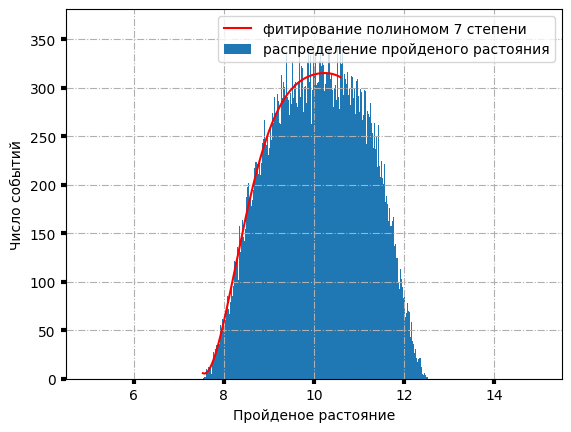

power =  8
 args =  [ 4.61274784e-02  1.86068486e+05 -4.11152271e+04  1.39100040e+04
 -2.10440671e+03  1.68823920e+02 -7.01607101e+00  1.19339417e-01
  0.00000000e+00]
 chi sq = 678.6922592458511
  1.3879187305641127


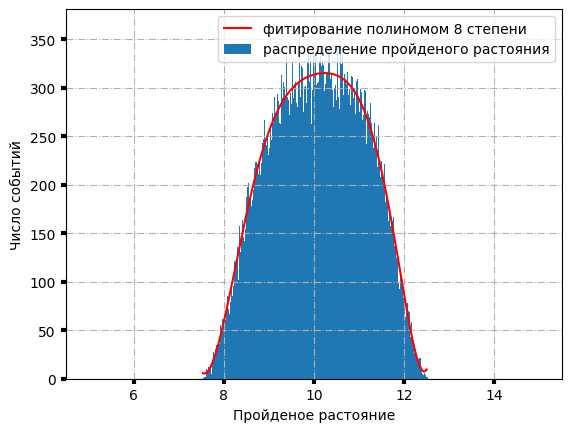

power =  9
 args =  [ 5.04083308e-02  1.83438452e+05 -4.07756379e+04  1.38492746e+04
 -2.10472634e+03  1.69580199e+02 -7.03948521e+00  1.13415718e-01
  5.24539376e-04 -1.28421361e-05]
 chi sq = 678.451561943408
  1.390269594146328


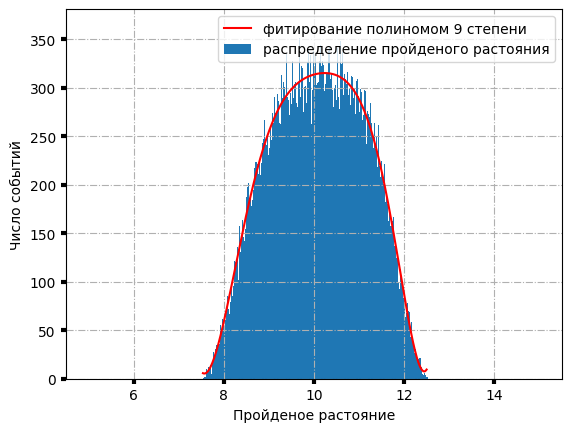

power =  10
 args =  [ 6.45635645e-02  5.78224484e+04 -2.63490698e+03 -1.19508897e+03
  3.92733428e+02  1.11778247e+01 -1.64991166e+01  2.59227844e+00
 -1.89825095e-01  6.93721696e-03 -1.02257058e-04]
 chi sq = 644.5999170565464
  1.3236137927239144


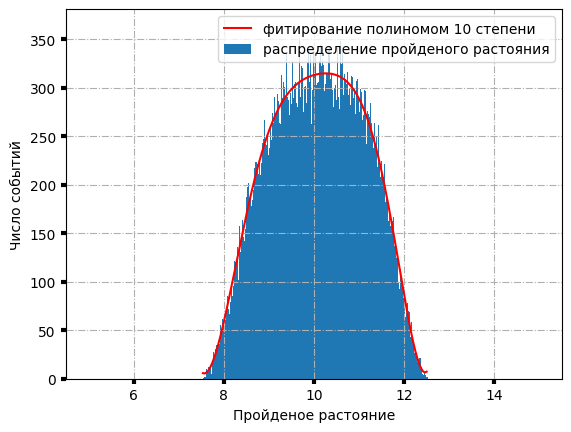

In [13]:
# Полином с экспанентой
a_zero = np.append(0.0, args_6)
for i_pow in range(7, 11):
    def pol_exp(x, *a):
        s = a[1]
        for i in range(2, i_pow+1):
            s+=a[i]*(x**i)
        return s*np.exp(x*a[0])
    args, covar = curve_fit(pol_exp, l[i_min:i_max], data[i_min:i_max], a_zero, absolute_sigma=True)

    a_zero = np.append(args, 0.0)

    perr = np.sqrt(np.diag(covar))
    print("power = ", i_pow)
    print(" args = ", args)

    # Подсчёт хи квадрата
    chisq=0
    for i in range(i_min, i_max):
        if data[i]>0:
          chisq += (data[i] - pol_exp(l[i], *args))**2/ data[i]
        else:
          chisq += (data[i] - pol_exp(l[i], *args))**2
    print(" chi sq =",chisq)
    print(" ", chisq/(i_max - i_min - i_pow))

    #Отрисовка
    x = []
    y = []
    for i in range(i_min, i_max):
        if pol(l[i], *args) > 0:
          x.append(l[i])
          y.append(pol_exp(l[i], *args))

    fig, ax = plt.subplots()
    ax.set_xlabel('Пройденое растояние')
    ax.set_ylabel('Число событий')
    ax.grid(True, linestyle='-.')
    ax.tick_params(labelsize='medium', width=3)

    ax.bar(l, data, linewidth = 1., width = err, label = "распределение пройденого растояния")
    ax.plot(x, y, color='r', label = "фитирование полиномом "+str(i_pow)+ " степени")
    ax.legend()
    pyplot.show()

## Поправки на осциляции нейтрино
Теперь мы мы иммеем вид распределения пройденых растояний $F(l)$. Так как он задан в не отнормированном виде, то достаточно поделить на $\int F(l)\ dl = const$. Этот нюанс в дальнейшем мало влияет на ход расчётов, по этому нормировка будет добавлена только в итоговой формуле

### Теория осциляций
Оснавная причина осциляций - собственный базис нейтриного триплета в массовом представлении не совбадает с собственном базисе в ароматном представлении:
$$| \nu \rangle = c_1 | \nu_e \rangle + c_2 | \nu_\mu \rangle + c_3 | \nu_\tau \rangle = b_1 | \nu_1 \rangle + b_2 | \nu_2 \rangle + b_3| \nu_3 \rangle$$

Расмотрм сначала киематику массовых состояний. Для собственных массовых состояний известен пропогатор:

$$ | \nu_i (t) \rangle = e^{-i\left(E_it - \bm{p} \bm{x}_i \right) } | \nu_i (0) \rangle $$

Из релятивиской динамики мы знаем дисперсионное соотношение (как и для любых частиц с массой): $E^2 = m^2 + p^2$, где принято $c=1$. В ультрарелятивиском пределе получаем: $E \sim p + \frac{2m}{p}$. Откуда $ | \nu_i (L) \rangle = \exp \left(-i \frac{m_i^2}{2E}L \right) | \nu_i (0) \rangle $

В ходе слабых процессов нейтрино рождаются в собственных состаяниях аромата, а значит в смеси массовых состояний. Тогда из-за дисперсионого соотношения получаем расплывание волнового пакета из массовых сотояний. А значит :

$ \sin \frac{\Delta m^2}{4E} L  = \sin \frac{kL}{E}$

$k= \frac{\Delta m^2}{4} \frac{1}{c\hbar}\sim \frac{1.0\cdot 10^{-6\cdot 2} \text{МэВ}^2}{4\cdot 197.32698\cdot 10^{-15} \text{МэВ}\cdot\text{м}}  \sim 1.267\ \text{МэВ}\cdot\text{м}^{-1}$

### Вычисление с фиксированой энергией
Сделаем свёртку F(l) с полученной функцией:

In [40]:
# подключим пакет интегрирования из библиотеки scipy
from scipy import integrate

In [93]:
def pol(x):
    s = args[0]
    for i in range(1, 10):
        s+=args[i]*(x**i)
    return s

pol_vectorized = np.vectorize(pol)

norm = integrate.quad(pol, l[i_min], l[i_max])[0]

pol_vectorized_norm = lambda x: pol_vectorized(x)/norm

In [94]:
splitting_of_masses_with_constants = 1.26
turning_the_basis = 0.1
E = 3
oscil_vectorized = np.vectorize(lambda x, y: np.sin(splitting_of_masses_with_constants*x/y)**2)

#Без учёта не точечности
P_point = np.vectorize(lambda e: 1 - 0.25 * turning_the_basis * oscil_vectorized(10, e))

#С учётом не точечности
product_function = lambda x : pol_vectorized_norm(x[0])*oscil_vectorized(x[0], x[1])
distribution_E = np.vectorize(lambda e: integrate.quad(np.vectorize(lambda x: product_function([x, e])), l[i_min], l[i_max])[0])
P_lengthy = lambda e: 1 - 0.25 * turning_the_basis * distribution_E(e)

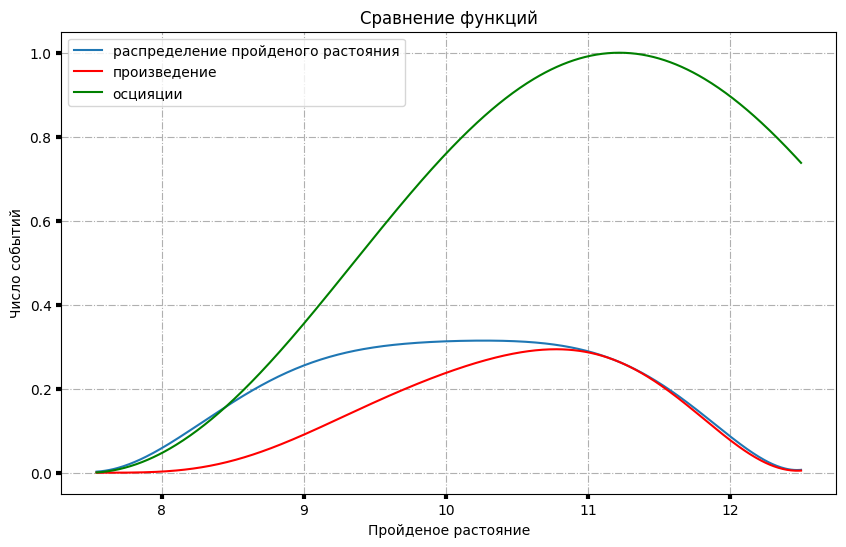

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Сравнение функций')
ax.set_xlabel('Пройденое растояние')
ax.set_ylabel('Число событий')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

ax.plot(l[i_min: i_max], pol_vectorized_norm(l[i_min: i_max]), label = "распределение пройденого растояния")
ax.plot(l[i_min: i_max], product_function([l[i_min: i_max], E]), color='r', label = "произведение")
ax.plot(l[i_min: i_max], oscil_vectorized(l[i_min: i_max], E), color='g', label = "осцияции")
ax.legend()
pyplot.show()

In [96]:
print("Результат свёртки при E =",E, "МэВ")
print("Вероятность детектирования электроного нейтрино, с учётом не точечности: ", P_lengthy(E), ", где свёртка: ", distribution_E(E))
print("Вероятность детектирования электроного нейтрино, без учёта не точечности: ", P_point(E), ", где свёртка: ", oscil_vectorized(10, E))

Результат свёртки при E = 3 МэВ
Вероятность детектирования электроного нейтрино, с учётом не точечности:  0.9826152535297505 , где свёртка:  0.6953898588099783
Вероятность детектирования электроного нейтрино, без учёта не точечности:  0.9810088918235415 , где свёртка:  0.7596443270583428


### Зависимость от энергии
Теперь узнаем как зависит результат от энергии пучка нейтрино

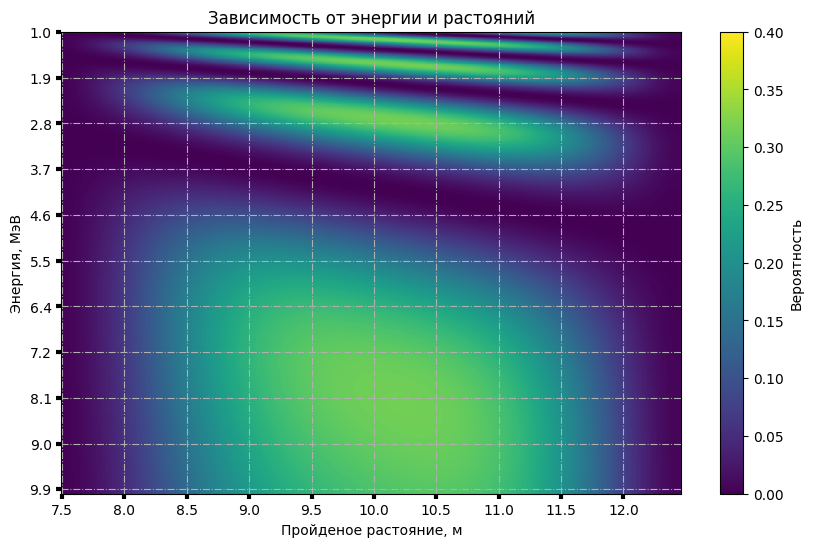

In [103]:
# Постороем зависимость от энергии
E_list = np.linspace(1, 10, 1010)

X, Y = np.meshgrid(l[i_min: i_max], E_list)

# Применение целевой функции
distribution_l_E = product_function([X, Y])


fig, ax = plt.subplots(figsize=(10, 6))
im = ax.matshow(distribution_l_E, aspect='auto', vmin=0, vmax=0.4)
ax.set_title('Зависимость от энергии и растояний')
ax.set_xlabel('Пройденое растояние, м')
ax.set_ylabel('Энергия, МэВ')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)
ax.xaxis.set_ticks_position('bottom')

x_indices = np.arange(0, len(l[i_min:i_max]), 50)
y_indices = np.arange(0, len(E_list), 100)

# Установка меток на осях
ax.set_xticks(x_indices)  # Только метки с индексами x_indices
ax.set_yticks(y_indices)  # Только метки с индексами y_indices
# Установка текста меток
ax.set_xticklabels([f"{l[i_min+i]:.1f}" for i in x_indices])  # Подписи оси X
ax.set_yticklabels([f"{E_list[i]:.1f}" for i in y_indices])   # Подписи оси Y

fig.colorbar(im, ax=ax, label='Вероятность')

plt.show()

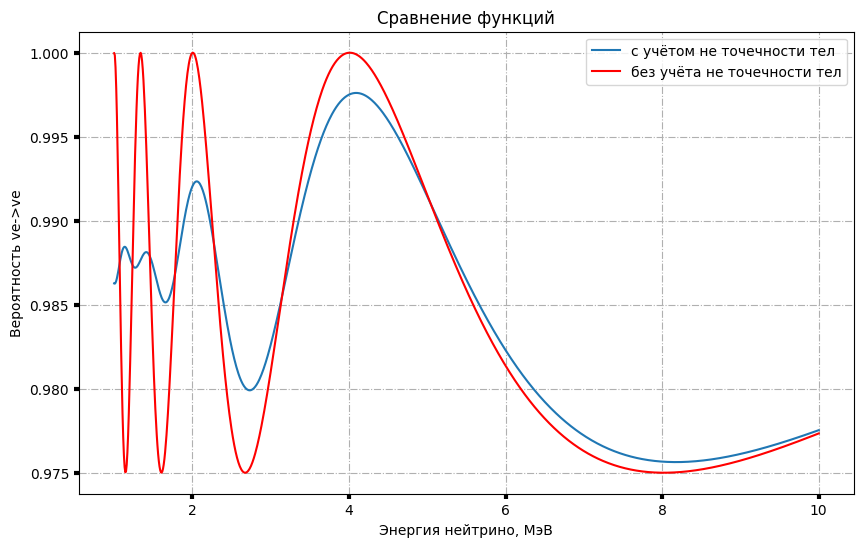

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Сравнение функций')
ax.set_xlabel('Энергия нейтрино, МэВ')
ax.set_ylabel('Вероятность ve->ve')
ax.grid(True, linestyle='-.')
ax.tick_params(labelsize='medium', width=3)

# ax.plot(E_list, distribution_E(E_list), label = "с учётом не точечности тел, свёртка")
ax.plot(E_list, P_lengthy(E_list), label = "с учётом не точечности тел")
# ax.plot(E_list, oscil_vectorized(10, E_list), color='r', label = "без учёта не точечности тел, свёртка")
ax.plot(E_list, P_point(E_list), color='r', label = "без учёта не точечности тел")
ax.legend()
pyplot.show()

## Результаты
